<img src="http://s3.amazonaws.com/pix.iemoji.com/images/emoji/apple/ios-12/256/waving-hand.png" align=left width=44, heigth=44>
<div class="alert alert-info">
<b> Комментарий ревьюера</b>


Привет, Кирилл! Давай знакомиться! Меня зовут Дмитрий Махортов, и я буду проверять твой проект. 

Моя основная цель — не указать на совершенные тобою ошибки, а поделиться своим опытом и помочь тебе погрузиться в увлекательный мир работы с данными и вырасти в крепкого профи. Это отдаленная цель. А ближайшая - сделать твою работу еще лучше )).
   
    
Все ключевые этапы в работе выполнены, и я вижу что с проектом ты справшяешься. Есть моменты, которые нужно доработать, но я уверен, у тебя все получится.
        
Расскажу как обычно проходит проверка:    
Бывают моменты, которые требуют пристального внимания. Комментарии по ним выделены <span style='background-color:#F7B3A4'> красным цветом </span> и обозначены значком 🛑. После их доработки проект будет принят.  🙂
 
<span style='background-color:#B7EBA7'> Зеленым цветом </span> и значком ✅ отмечены удачные и элегантные решения, на которые можно опираться в будущих проектах. Или советы «со звездочкой», которые помогут тебе в будущем.

<span style='background-color:#F9EDA6'>Жёлтым цветом </span> и значком ⚠️ выделено то, что в следующий раз можно сделать по-другому. Ты можешь учесть эти комментарии при выполнении будущих заданий или доработать проект сейчас (однако это не обязательно).

Давай работать над проектом в диалоге: **если ты что-то меняешь в проекте по моим рекомендациям — пиши об этом**. Выбери для своих комментариев какой-то заметный цвет, так мне будет легче отследить изменения. Пожалуйста, **не перемещай, не изменяй и не удаляй мои комментарии**. Всё это поможет выполнить повторную проверку твоего проекта оперативнее. 
</div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>образец комментария студента</b></font>
   
Можешь использовать этот комментарий. Просто удали этот текст и вместо него напиши свой 🙂

</div>

# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные находятся [здесь](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` собрана информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


In [1]:
# !pip install tqdm pandarallel transformers wordcloud ipywidgets Pillow

In [2]:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
У меня создалось ощущение, что ты устанавливаешь очень много лишних библиотек. Попробую пояснить свою идею.
    
Я вижу что ты работаешь в локальном окружении, а значит установка одной библиотеки делается один раз (ты это сделал в ноутбуке, но можно и через итерфейс анаконды или командную строку (терминал).
    
А для сред, где этот ноутбук может загружаться многие из ипользованных тобой библиотек уже установлены. В лиюбом случае ты же не устанавливаешь абсолютно все. Например для запуска твоего кода в колабе мне потербовалось только 
    
    
    transformers wordcloud pandarallel
    
Но если установка библиотеки нужна, то можно добавить флаг -q и соединить все установки в одну строку. Будет гораздо аккуратноее.
    
    !pip install -q  transformers wordcloud pandarallel
    
    
А еще советую провести ревизию, все ли библиотеки тебе нужны. Вижу "исключающие" друг друга устновки и импорты, скорее всего ты просто не сделал "генеральную уборку" после экспериментов.    
</div>

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from os import listdir

import matplotlib.pyplot as plt
from wordcloud import WordCloud

import transformers
from transformers import AutoFeatureExtractor, TFResNetModel
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GroupShuffleSplit

from tqdm import tqdm

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

tqdm.pandas()

from torch.utils.data import DataLoader, Dataset, TensorDataset

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression 
from catboost import CatBoostRegressor

import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, Flatten, Dense, AvgPool2D, Dropout
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.applications.resnet50 import preprocess_input


2023-08-26 06:52:46.865731: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-26 06:52:49.187396: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.so
2023-08-26 06:52:49.187517: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdxcore.so
2023-08-26 06:52:49.191174: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libd3d12.so
2023-08-26 06:52:49.551925: I tensorflow/c/logging.cc:34] DirectML device enumeration: found 1 compatible adapters.


INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [4]:
ORIGINAL_DIR = './to_upload'

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Большое тебе человеческое спасибо за вынос пути к данным в отдельную константу. Это сэкономило мне немало времени при проверке.</div>

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Stop_sign.png/240px-Stop_sign.png" align=left width=35, heigth=35>
<div class="alert alert-danger">
Но при перезапуске проекта у меня возникли большие сложности связанные с тем, что ты руками поменял данные, в частности у тебя появилась директория images, но в данных, которые я могу скачать с сервера Практикума есть папки с обучающими и тестовыми изображениями. Прошу тебя внести изменения в проект чтобы он запускался на корректном датасете.</div>

## Подготовка данных разметки

In [5]:
crowd_annotations = pd.read_csv(f'{ORIGINAL_DIR}/CrowdAnnotations.tsv', delimiter='\t', header=None)
crowd_annotations.columns = ['image', 'query_id', 'percent', 'positive', 'negative']

In [6]:
crowd_annotations.head()
crowd_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   image     47830 non-null  object 
 1   query_id  47830 non-null  object 
 2   percent   47830 non-null  float64
 3   positive  47830 non-null  int64  
 4   negative  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [7]:
expert_annotations = pd.read_csv(f'{ORIGINAL_DIR}/ExpertAnnotations.tsv', delimiter='\t', header=None)
expert_annotations.columns = ['image', 'query_id', 'expert_0', 'expert_1', 'expert_2']

In [8]:
expert_annotations.head()
expert_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   expert_0  5822 non-null   int64 
 3   expert_1  5822 non-null   int64 
 4   expert_2  5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


In [9]:
def get_expert(record):
    marks = [0, 0, 0, 0]

    marks[record['expert_0'] - 1] += 1
    marks[record['expert_1'] - 1] += 1
    marks[record['expert_2'] - 1] += 1

    for i in range(len(marks)):
        if (marks[i] == 2) | (marks[i] == 3):
            return i + 1

    return 0

expert_annotations['mark'] = expert_annotations.apply(get_expert, axis=1)

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
    
Отсутствует этап знакомства с данными и хотя-бы очень беглый EDA. Ты сразу пошел "в бой" им начал преобразовывать датафреймы.
    
Но в любом проекте нужно вначале осмыслено и системно познакомиться с даннными, и только потом начинать их вдумчиво преобразовывать, готовить признаки для машинного  обучения.
    
    
Что бы я сделал (программа минимум): посмотрел на все доступные таблицы через head/info/describe,  + посмотрел на изображения. Попробую сформулировать вопросы, ответить на которые будет интересно:
  - Количество уникальных изображений в обучающем и тестовом наборах
  - Количество уникальных запросов  
  - Количество оценок в экспертном и краудсорсинговом наборах.
  - Как мы планируем обрабатывать данные (какие оценки как использовать для формирования итогового датафрейма с оценками)   
    
    
</div>

In [10]:
expert_annotations = expert_annotations[expert_annotations['mark'] > 0]
expert_annotations['percent_expert'] = expert_annotations['mark'] / 4

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
Не стоит выводить весь датафрейм. Да, внешне ты видишь первые и последние пять строк. Но под капотом интерпретатор python работает со всем датафреймом, занимается оперативная память, пишутся служебные файлы... По итогу это может привести к замедлению работы и проблемам с работоспособностью тетрадки.
    
Лучше всегда явно ограничивать количество обрабатываемых значений.
    
Советую использовать пару head + info()    
</div>

In [11]:
crowd_annotations['sum'] = crowd_annotations['positive'] + crowd_annotations['negative']
crowd_annotations['percent_crowd'] = crowd_annotations['positive'] / crowd_annotations['sum']

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
То, что ты высчитываешь как percent_crowd уже есть в percent
    
</div>

In [12]:
marks = crowd_annotations.merge(expert_annotations, how='outer', on=['query_id', 'image'])[['image', 'query_id', 'percent_crowd', 'percent_expert']]

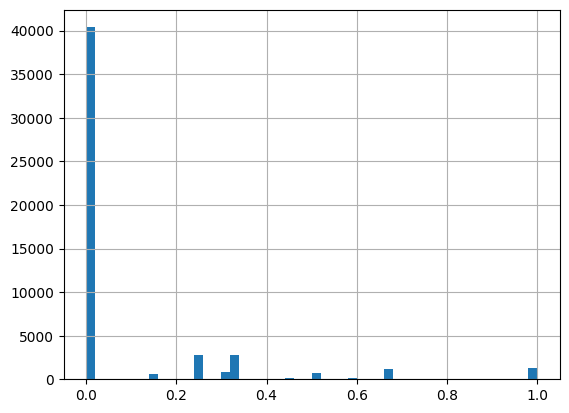

In [13]:
def get_mark(record):
    if np.isnan(record['percent_crowd']):
        return record['percent_expert']
    
    if np.isnan(record['percent_expert']):
        return record['percent_crowd']
    
    return record['percent_crowd'] * 0.4 + record['percent_expert'] * 0.6

marks['target'] = marks.apply(get_mark, axis=1)
marks['target'].hist(bins=50)
None

In [14]:
marks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51268 entries, 0 to 51267
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image           51268 non-null  object 
 1   query_id        51268 non-null  object 
 2   percent_crowd   47830 non-null  float64
 3   percent_expert  5696 non-null   float64
 4   target          51268 non-null  float64
dtypes: float64(3), object(2)
memory usage: 2.0+ MB


</div><img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
    
Давай еще раз проанализиуем что ты сделал.  У тебя был датасет с экспертными оценками (почти 6000 оценок). Ты объединил их с краудсорс-оценками (кстати, их было 48000), но т.к. ты использовл inner_join, то у тебя осталось всего 2258 оценки...
    
Ради сомнительного улучшения качества потерять половину доступных оценок - это крайне расточительно.   
    
Кстати, в этой задаче можно попробовать использовать все оценки (и тогда датасет будет не 2258, а больше 50000 пар текст-изображение).  Нужно просто сделать outrer join и аккуратно обработать оценки:
    
   - Привести экспертные оценки и краудсорс оценки к масштабу 0-1
   - Если есть оба типа оценок, то использовать взвешенную сумму
   - Если есть только одна оценка, то использовать её.
 
    
Помни, что сбор данных это достаточно дорогой и трудоемкий процесс.  И разбрасываться ими это моветон.    
</div>

## Данные о фотографиях.

In [15]:
test_images_df = pd.read_csv(f'{ORIGINAL_DIR}/test_images.csv')
test_queries = pd.read_csv(f'{ORIGINAL_DIR}/test_queries.csv', delimiter='|', index_col=[0])
train_dataset = pd.read_csv(f'{ORIGINAL_DIR}/train_dataset.csv')

In [16]:
display(test_images_df.sample(10, random_state=1234))
test_images_df.info()

,image
40,3466891862_9afde75568.jpg
35,3033612929_764d977bd5.jpg
81,3514297698_0512623955.jpg
61,3690425778_3b390b3ea5.jpg
98,2670637584_d96efb8afa.jpg
68,957682378_46c3b07bcd.jpg
85,3398788809_25c71ba018.jpg
27,3287969199_08e775d896.jpg
39,381514859_b40418d9c3.jpg
42,3520936130_9e90872560.jpg


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
Для всех загруженных таблиц не забывай смотреть размер через shape или info, эта информация не менее ценна, чем просто посмотреть несколько строк.
    
    
P.S. увидел, что ты смотришь info() несколкими ячейками ниже. Но это жутко неудобно, одновременно знакомиться с несколькими таблицами. Лучше изучать их по одной. Иначе получается что чисто формально ты вывел нужную информацию, но читатель пока изучит все sample уже забудет что было в первом. И придется листать проект туда-сюда, постоянно путаясь.

In [17]:
display(test_queries.sample(10, random_state=1234))
test_queries.info()

,query_id,query_text,image
67,2121140070_a09644550b.jpg#2,A group of people in a large yard toss a disc .,2121140070_a09644550b.jpg
416,3722572342_6904d11d52.jpg#1,A red high speed racing boat skips across the ...,3722572342_6904d11d52.jpg
350,3459871361_92d1ecda36.jpg#0,A bicyclist is jumping on ramp covered with gr...,3459871361_92d1ecda36.jpg
358,3466891862_9afde75568.jpg#3,The small dog returns with his stick proudly .,3466891862_9afde75568.jpg
112,2448210587_9fe7ea5f42.jpg#2,A white bulldog sitting on a tree stump gives ...,2448210587_9fe7ea5f42.jpg
329,3421547427_53411b6278.jpg#4,The tennis player in the blue shirt is holding...,3421547427_53411b6278.jpg
299,3351418768_596ef7fd6f.jpg#4,A woman in purple with two children in the mou...,3351418768_596ef7fd6f.jpg
64,2107838729_a527e434bd.jpg#4,Little boy standing on the bank of a river .,2107838729_a527e434bd.jpg
27,1468389504_c724bdcad0.jpg#2,Two little girls in pink outfits play on a yel...,1468389504_c724bdcad0.jpg
373,3488087117_2719647989.jpg#3,Little brown and white dog running on the side...,3488087117_2719647989.jpg


<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


In [18]:
display(train_dataset.sample(10, random_state=1234))
train_dataset.info()

,image,query_id,query_text
3745,542317719_ed4dd95dc2.jpg,2522297487_57edf117f7.jpg#2,a white woman in a green sweater holds a smili...
4492,3523874798_9ba2fa46e3.jpg,3702436188_2c26192fd0.jpg#2,A person on a skateboard .
2982,1674612291_7154c5ab61.jpg,3016606751_0e8be20abd.jpg#2,A man steps off of a boulder .
1663,136644343_0e2b423829.jpg,2518508760_68d8df7365.jpg#2,A greyhound wearing a muzzle and the number si...
2529,3571147934_d1c8af1d6e.jpg,1258913059_07c613f7ff.jpg#2,Three people sit at an outdoor cafe .
4164,491405109_798222cfd0.jpg,2490768374_45d94fc658.jpg#2,a young girl wearing blue smiles .
4855,979383193_0a542a059d.jpg,3585598356_8ce815bbb9.jpg#2,two woman are showing different facial express...
3240,3220161734_77f42734b9.jpg,3197981073_3156963446.jpg#2,A woman sings into a microphone while playing ...
1961,3375549004_beee810e60.jpg,2612488996_9450de0e54.jpg#2,A homeless man stands with a sign next to oran...
4394,3182121297_38c99b2769.jpg,2358561039_e215a8d6cd.jpg#2,Several dogs carry a man with a helmet through...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [19]:
len(test_queries['image'].unique())

100

In [20]:
len(train_dataset['image'].unique())

1000

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
А вот объединение тестовых данных с обучающими это абсолютно лишнее. Зачем ты это делаешь? Наоборот, хорошим тоном является "отложить тестовые даные подальше и никак их не использовать". И вот сейчас, когда ты получил тестовые данные в отдельных табличках ты все равно соединяешь их с обучающими.</div>

In [21]:
df = marks.merge(train_dataset, on=['query_id', 'image'], how='inner')
display(df.head())
df.info()

,image,query_id,percent_crowd,percent_expert,target,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.000000,0.25,0.150000,A young child is wearing blue goggles and sitt...
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.000000,0.25,0.150000,A girl wearing a yellow shirt and sunglasses s...
2,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,0.000000,0.25,0.150000,A man and woman look back at the camera while ...
3,1082379191_ec1e53f996.jpg,1536774449_e16b1b6382.jpg#2,0.000000,NaN,0.000000,A crowd of people at an outdoor event
4,1084040636_97d9633581.jpg,256085101_2c2617c5d0.jpg#2,0.333333,0.75,0.583333,Close-up of dog in profile with mouth open .


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5767 entries, 0 to 5766
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image           5767 non-null   object 
 1   query_id        5767 non-null   object 
 2   percent_crowd   2329 non-null   float64
 3   percent_expert  5696 non-null   float64
 4   target          5767 non-null   float64
 5   query_text      5767 non-null   object 
dtypes: float64(3), object(3)
memory usage: 270.5+ KB


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Stop_sign.png/240px-Stop_sign.png" align=left width=35, heigth=35>
<div class="alert alert-danger">
Я вижу абслютно лишние действия... Вначале ты соединяешь данные испльзуя right-соединение, естественно туда попадают тестовые записи, и затем чистишь их руками. Пожалуйста убери все лишние операции. 

У тебя уже был датафрейм marks с оценками. Просто добавь в него строку с текстовыми описаниями, вся нужная информация есть в train_dataset. И не нужно в подготовке данных использовать тестовую выборку.

</div>

## Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

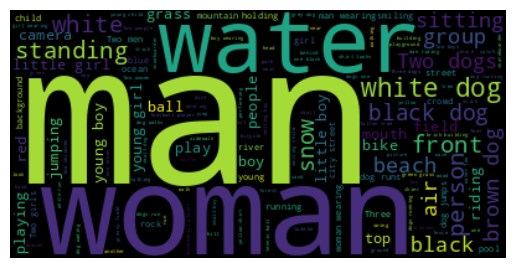

In [22]:
wordcloud = WordCloud().generate(' '.join(df['query_text']))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [25]:
illegal_words = ['boy', 'boys', 'girl', 'girls', 'young', 'child', 'children']

def filter_illegal_words(x):
    return len(list(set(x.split(' ')) & set(illegal_words))) > 0

df = df[~df['query_text'].apply(filter_illegal_words)].reset_index(drop=True)

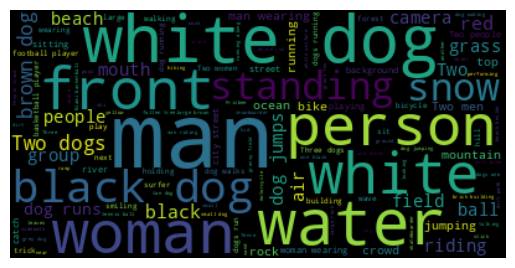

In [295]:
wordcloud = WordCloud().generate(' '.join(df['query_text']))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Stop_sign.png/240px-Stop_sign.png" align=left width=35, heigth=35>
<div class="alert alert-danger">
Прошу почистить датасет от изображений с детьми.

</div>

## Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


In [26]:
MAX_LENGTH = max(df['query_text'].apply(lambda x: len(x)))
print(MAX_LENGTH)

tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize(text, tokenizer, max_length):
    ids = tokenizer.encode(
        text,
        truncation=True,
        max_length=max_length,
        padding='max_length',
        add_special_tokens=True
    )
    return ids

def get_padded_mask(tokenized):
    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)

    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
    attention_mask = np.where(padded != 0, 1, 0)

    return padded, attention_mask
    
tokenized = df['query_text'].parallel_apply(tokenize, tokenizer=tokenizer, max_length=MAX_LENGTH)
padded, attention_mask = get_padded_mask(tokenized)

153


In [ ]:
# def get_bert_embeddings(padded, attention_mask, batch_size=32):
#     device = 'cuda' if torch.cuda.is_available() else 'cpu'

#     bert = transformers.AutoModel.from_pretrained("distilbert-base-uncased")
#     bert = bert.to(device)

#     embeddings = []

#     for i in tqdm(range(padded.shape[0] // batch_size)):
        
#         batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).to(device)
        
#         attention_mask_batch = torch.BoolTensor(attention_mask[batch_size*i:batch_size*(i+1)]).to(device)

#         with torch.no_grad():
#             batch_embeddings = bert(
#                 input_ids=batch, 
#                 attention_mask=attention_mask_batch
#             )

#             last_hidden_states = batch_embeddings.last_hidden_state.to('cpu')

#             embeddings += last_hidden_states[:, 0, :].tolist()

#     return embeddings

In [27]:
def get_bert_embeddings(padded, attention_mask, batch_size=32):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    bert = transformers.AutoModel.from_pretrained("distilbert-base-uncased")
    bert = bert.to(device)

    embeddings = []

    for i in tqdm(range(padded.shape[0] // batch_size)):
        
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).to(device)
        
        attention_mask_batch = torch.BoolTensor(attention_mask[batch_size*i:batch_size*(i+1)]).to(device)

        # batch_embeddings = bert(batch, attention_mask=attention_mask_batch) 

        with torch.no_grad():
            batch_embeddings = bert(
                input_ids=batch, 
                attention_mask=attention_mask_batch
            )

        embeddings.append(batch_embeddings[0][:,0,:].to('cpu').numpy()) 

            # last_hidden_states = batch_embeddings.last_hidden_state.to('cpu')

            # embeddings += last_hidden_states[:, 0, :].tolist()

    return np.concatenate(embeddings) 

In [28]:
text_embeddings = get_bert_embeddings(padded, attention_mask)

100%|██████████| 136/136 [00:08<00:00, 15.78it/s]


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Stop_sign.png/240px-Stop_sign.png" align=left width=35, heigth=35>
<div class="alert alert-danger">
К сожалению векторизацию с помощю BERT ты выполнил неверно. Основаня идея - получения эмбеддинга с помощью модели BERT. А ты просто испольовал номера токенов в словаре (деленные на длинну словаря) как признак, что не соответствет тому, что мы изучали в курсе.

Пожалуйста переделай этот пункт, советую обратиться к спринту "МО для текстов", там есть все образцы кода.
</div>

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
Еще пара замечаний. Если   тебя есть текстовое описание -  у него должно быть вектопрное представление. Отккуда взялись пропуски мне не очень понятно.

И второе. Не нужно "тянуть" матрицы признаков в датафрейм. Советую оставаться в матрицах нумпай, это базовый тип данных для машинного обучения.
</div>

#### Вывод:
Был сформирован датасет с текстами, закодированными с помощью DistilBert.

## Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [407]:
images = train_dataset['image'].unique()

# def resize_img_to_array(img, img_shape):
#     img_array = np.array(
#         img.resize(
#             img_shape,
#             Image.LANCZOS
#         )
#     )
#     return img_array
    
def get_image_embeddings(images, dir):
    feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/resnet-18")
    model = ResNetModel.from_pretrained("microsoft/resnet-18").to(device)
    # img_width, img_height = 224, 224

    embeddings = []
    for i in tqdm(range(len(images))):
        filename = images[i]
        image = Image.open(f'{dir}/{filename}')
        # image = resize_img_to_array(image, img_shape=(img_width, img_height))

        inputs = feature_extractor(image, return_tensors="pt").to(device)
        with torch.no_grad():
            result = model(**inputs)
        # last_hidden_state = model(**inputs).last_hidden_state
        image_features = result.last_hidden_state.to('cpu').numpy()
        # image_features /=  np.linalg.norm(image_features)
        embeddings.append(image_features)
        # embeddings[filename] = last_hidden_state[0, :, 0, 0].to('cpu').flatten().tolist()

    features = np.concatenate(embeddings)
    
    indexed_embeddings = {}
    for i in range(len(images)):
        indexed_embeddings[images[i]] = features[i]
        
    return indexed_embeddings

image_embeddings = get_image_embeddings(images, dir=f'{ORIGINAL_DIR}/train_images')


/home/k-avtonomov/miniconda3/envs/tfdml_plugin/lib/python3.9/site-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(
100%|██████████| 1000/1000 [00:16<00:00, 61.01it/s]

512
[[[1.5060353  1.5835983  0.01792448 ... 0.         0.         0.        ]
  [1.938074   2.4828906  1.913559   ... 0.425573   0.         0.        ]
  [0.661551   1.6640606  2.037918   ... 0.2302537  0.         0.        ]
  ...
  [0.         0.         0.93475723 ... 0.5509278  0.0194956  0.        ]
  [0.02871672 0.         0.0685823  ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.46298775 0.5680139 ]]

 [[3.2060742  4.7338033  5.772869   ... 4.3773384  4.2286677  4.8639097 ]
  [4.4212494  5.8416986  6.3705697  ... 3.6366894  3.3829565  4.0214124 ]
  [4.647407   5.145937   5.4578586  ... 3.2142198  2.6673038  2.9008577 ]
  ...
  [4.1817565  3.7385077  2.4808238  ... 0.         1.6465532  2.1080282 ]
  [3.1611962  2.4068496  1.9316483  ... 0.2670587  2.120331   2.3386343 ]
  [1.2714906  0.6211267  0.28119454 ... 0.         1.0990478  1.3696591 ]]

 [[2.4573286  3.3799546  2.3587403  ... 2.1475785  3.0384233  2.3768497 ]
  [3.8345306  5.60

In [30]:
res_net_model = ResNet50(weights='imagenet', include_top=False,input_shape=(224, 224, 3), pooling='max')

def read_img_file(f):
    img = Image.open(f)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    return img

def resize_img_to_array(img, img_shape):
    img_array = np.array(
        img.resize(
            img_shape,
            Image.LANCZOS
        )
    )
    return img_array

def get_features(img):
    img_width, img_height = 224, 224
    np_img = resize_img_to_array(img, img_shape=(img_width, img_height))
    expanded_img_array = np.expand_dims(np_img, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    X_conv = res_net_model.predict(preprocessed_img, verbose=0)
    image_features=X_conv[0]
    image_features /=  np.linalg.norm(image_features)
    return image_features

images = train_dataset['image'].unique()

def get_image_embeddings2(images, dir):
    embeddings = {}

    for i in tqdm(images):
        image = read_img_file(f'{dir}/{i}')
        embeddings[i] = get_features(image)

    return embeddings

image_embeddings = get_image_embeddings2(images, dir=f'{ORIGINAL_DIR}/train_images')

2023-08-26 06:55:04.903535: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-26 06:55:04.904579: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (NVIDIA GeForce RTX 3070)
2023-08-26 06:55:05.115359: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-26 06:55:05.115408: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:28] Overriding allow_growth setting because force_memory_growth was requested by the device.
2023-08-26 06:55:05.115432: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

In [ ]:
# image_embeddings = get_image_embeddings(images, dir=f'{ORIGINAL_DIR}/train_images')
# print(len(image_embeddings[images[0]]))

In [230]:
# images = pd.DataFrame(listdir(f'{ORIGINAL_DIR}/images'), columns=['image'])
# images = images[images['image'] != '.DS_Store']

In [231]:
# def read_img_features(filename, ORIGINAL_DIR=ORIGINAL_DIR, get_features=get_features):
#     image = Image.open(f'{ORIGINAL_DIR}/images/{filename}')
#     return get_features(image)

# images['tensor'] = images['image'].progress_apply(read_img_features, ORIGINAL_DIR=ORIGINAL_DIR, get_features=get_features)

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Здесь все ОК, векторизация изображений произведена верно </div>

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
Но вот центральным объектом у тебя по прежнему является датафрейм, где ты собираешь все признаки, даже функция заточена под это...  

Более оптимальной практикой является создание датагенератора, который будет пропускать изображения пачками и формировать матрицу признаков.
    
        

</div>

#### Вывод:
Был сформирован обьект с изображениями, из которых с помощью ResNet18 был получен вектор, длиной 512.

## Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [439]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4369 entries, 0 to 4368
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image           4369 non-null   object 
 1   query_id        4369 non-null   object 
 2   percent_crowd   1832 non-null   float64
 3   percent_expert  4316 non-null   float64
 4   target          4369 non-null   float64
 5   query_text      4369 non-null   object 
dtypes: float64(3), object(3)
memory usage: 204.9+ KB


In [31]:
embeddings = []
targets = []
image_labels = []
for i in range(len(text_embeddings)):
    record = df.iloc[i]
    embeddings.append(np.concatenate([image_embeddings[record['image']], text_embeddings[i]]))
    targets.append([record['target']])
    image_labels.append([record['image']])

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
 Вектора, полученные из текста и изображения объеденены👍 </div>

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
Соединенеие признаков внутри одного датафрейма приводит к сильным затратам по памяти..  Как я уже писал тебе ранее, правильнее все матрицы признаков хранрить в формате numpy array и конкатенировать.
</div>

#### Вывод:
Здесь объединены вектора изображений (512) и текстов (768) с целевой переменной.

## Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Stop_sign.png/240px-Stop_sign.png" align=left width=35, heigth=35>
<div class="alert alert-danger">
Здесь я вижу путаницу в выборках. Тестовая выборка (на чем мы должны оценивать итоговую модель) - это именно то, что ты загружил из отдельных файлов. А то, что ты ниже отрезаешь от обучающей выборке - это и есть валидационная. По ней мы подбираем гиперпараметры или оцениваем модели.  </div>

In [32]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=embeddings, y=targets, groups=image_labels))
# train_df, test_df = train_test_df.loc[train_indices], train_test_df.loc[test_indices]

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Отлично, благодаря использованию GroupShuffleSplit ты исключаешь попадание одного изображения в обучающий и валидационный наборы.</div>

In [33]:
def score_model(model, features, target):
    '''Вывод значений F1 и AUC-ROC'''
    predictions = model.predict(features)
    print(f'RMSE {mean_squared_error(target, predictions, squared=False)}')

In [50]:
features_train = pd.DataFrame(np.array(embeddings)[np.array(train_indices)])
target_train = pd.DataFrame(np.array(targets)[np.array(train_indices)])
features_test = pd.DataFrame(np.array(embeddings)[np.array(test_indices)])
target_test = pd.DataFrame(np.array(targets)[np.array(test_indices)])

catboost = CatBoostRegressor(verbose=100)
catboost.fit(features_train, target_train)

predictions_test = catboost.predict(features_test)
print(f'MSE {mean_squared_error(target_test, predictions_test, squared=True)}')

Learning rate set to 0.048824
0:	learn: 0.2077361	total: 532ms	remaining: 8m 51s
100:	learn: 0.1680964	total: 16.9s	remaining: 2m 30s
200:	learn: 0.1445812	total: 30.9s	remaining: 2m 3s
300:	learn: 0.1210387	total: 44.5s	remaining: 1m 43s
400:	learn: 0.1034566	total: 58.1s	remaining: 1m 26s
500:	learn: 0.0883085	total: 1m 11s	remaining: 1m 11s
600:	learn: 0.0758896	total: 1m 25s	remaining: 56.6s
700:	learn: 0.0656282	total: 1m 38s	remaining: 42.2s
800:	learn: 0.0575423	total: 1m 52s	remaining: 27.9s
900:	learn: 0.0505527	total: 2m 5s	remaining: 13.8s
999:	learn: 0.0441580	total: 2m 19s	remaining: 0us
RMSE 0.18799089827647977


In [66]:
seq_clf = nn.Sequential(
    nn.Linear(768+2048,1024),
    nn.ReLU(),
    # nn.Linear(1024, 512),
    # nn.ReLU(),
    # nn.Linear(512, 248),
    # nn.ReLU(),
    # nn.Linear(248, 64),
    # nn.ReLU(),
    nn.Linear(1024, 1),
    nn.ReLU(),
)

In [67]:
def train_nn(net, X_train, y_train, X_test, y_test, num_epochs = 100, period = 10, batch_size = 100, verbose=True):
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

    loss = nn.MSELoss()

    for epoch in range(num_epochs):
        for i, (x, y) in enumerate(train_loader): 

            optimizer.zero_grad()
            # print(x, y)
            preds = net.forward(x).flatten()


            loss_value = loss(preds, y)

            loss_value.backward()

            optimizer.step()

        
        if epoch % period == 0 or epoch == num_epochs - 1:
            with torch.no_grad():
                net.eval()
                test_preds = net.forward(X_test)
                test_preds = torch.reshape(test_preds.detach(), (-1,))

                score = mean_squared_error(test_preds, y_test, squared=True)

                if verbose:
                    print(f'RMSE: {score}')

                net.train()
        
    return score, net  

In [68]:
train_nn(
    seq_clf, 
    torch.Tensor(np.array(embeddings)[np.array(train_indices)]),
    torch.Tensor(np.array(targets)[np.array(train_indices)]),
    torch.Tensor(np.array(embeddings)[np.array(test_indices)]),
    torch.Tensor(np.array(targets)[np.array(test_indices)])
)

RMSE: 0.16597867012023926


/home/k-avtonomov/miniconda3/envs/tfdml_plugin/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([100, 1])) that is different to the input size (torch.Size([100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/k-avtonomov/miniconda3/envs/tfdml_plugin/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([47, 1])) that is different to the input size (torch.Size([47])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RMSE: 0.16597867012023926


/home/k-avtonomov/miniconda3/envs/tfdml_plugin/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([100, 1])) that is different to the input size (torch.Size([100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/k-avtonomov/miniconda3/envs/tfdml_plugin/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([47, 1])) that is different to the input size (torch.Size([47])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


KeyboardInterrupt: 

In [450]:
# model = Sequential()
# model.add(Dense(768+512, activation='relu'))
# model.add(Dropout(rate=0.2))
# model.add(Flatten())
# model.add(Dense(units=1024, activation='relu'))
# model.add(Dense(units=512, activation='relu'))
# model.add(Dense(units=248, activation='relu'))
# model.add(Dense(units=64, activation='relu'))
# model.add(Dense(units=1, activation='relu'))

# optimizer = Adam(learning_rate=0.0005)

# model.compile(optimizer=optimizer, loss='mse', metrics=[MeanAbsoluteError()])

# model.fit(pd.DataFrame(train_test_df['features'].to_list()).add_prefix('feature_'), train_test_df['target'], batch_size=32, epochs=40)

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
Во первых, количество нейронов в первом слое модели может быть любым, оно не обязано совпадать с размерностью вектора признака.

Во вторых, не нужно добавлять Flatten после каждого слоя. Потому что после применения полносвязного слоя к вектору получается снова вектор (полносвязный слой эквивалентен умножению на матрицу + добавление вектора смещения и применение нелинейности).
    
Также старайся количество нейронов в слое и размер батча привязывать к степени 2. Так оптимальнее с точки зрения испльзования ресурсов видеокарты. 512...64...64... 16....8    
</div>

#### Вывод
В качестве метрики качества выбрана MAE, поскольку необходимо предсказать значение схожести в промежутке [0,1], это позволяет наглядно видеть, насколько сильно ошибается модель.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Stop_sign.png/240px-Stop_sign.png" align=left width=35, heigth=35>
<div class="alert alert-danger">
Ты иследовал только одну модель, но по условиям проекта моделей должно быть минимум две. Можешь попробовать использовать любую  "классическую" модель, например линейную регрессию или бустинг.</div>

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [42]:
test_queries = test_queries[~test_queries['query_text'].apply(filter_illegal_words)].reset_index(drop=True)

In [43]:
test_queries_sample = test_queries.sample(10, random_state=1234).reset_index(drop=True)

In [44]:
test_images = np.array(test_images_df['image'])
test_image_embeddings = get_image_embeddings2(test_images, dir=f'{ORIGINAL_DIR}/test_images')

tokenized = test_queries_sample['query_text'].progress_apply(tokenize, tokenizer=tokenizer, max_length=MAX_LENGTH)
padded, attention_mask = get_padded_mask(tokenized)
test_text_embeddings = get_bert_embeddings(padded, attention_mask, batch_size=10)

100%|██████████| 1/1 [00:00<00:00,  6.30it/s]


In [45]:
test_labels = []
test_embeddings = []
for i in test_queries_sample.index:
    for j in test_image_embeddings:
        record = test_queries_sample.loc[i]
        _text_embedding = test_text_embeddings[i]

        _image_embedding = test_image_embeddings[j]
        test_labels.append(np.array([record['query_id'], record['query_text'], j]))
        test_embeddings.append(np.concatenate([_text_embedding, _image_embedding]))

In [46]:
test_predictions = model.predict(test_embeddings)

In [47]:
test_labels_df = pd.DataFrame(test_labels)
test_labels_df.columns = ['query_id', 'query_text', 'image']
test_labels_df['predict'] = test_predictions

In [48]:
test_labels_df = test_labels_df[test_labels_df.groupby(['query_id'])['predict'].transform(max) == test_labels_df['predict']].reset_index(drop=True)

/tmp/ipykernel_980/2463020365.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


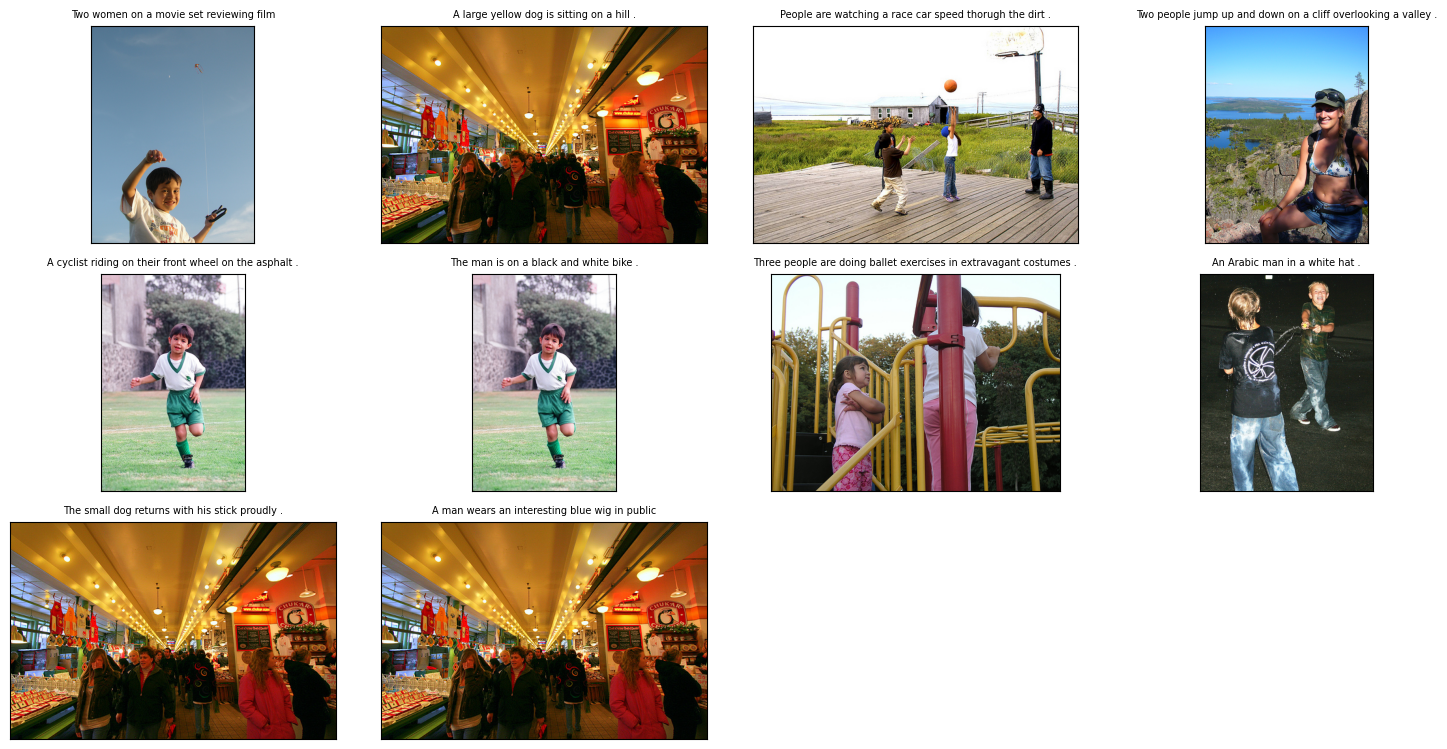

In [49]:
fig = plt.figure(figsize=(15,20))
for i in test_labels_df.index:
    record = test_labels_df.loc[i]
    fig.add_subplot(8, 4, i+1)
    image = Image.open(f'{ORIGINAL_DIR}/test_images/{record["image"]}')
    plt.imshow(np.array(image))
    plt.xticks([])
    plt.yticks([])
    plt.title(test_labels_df.loc[i, 'query_text'], fontsize=7, wrap=True)
    plt.tight_layout()

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Stop_sign.png/240px-Stop_sign.png" align=left width=35, heigth=35>
<div class="alert alert-danger">
Дальше проверить не могу - при перезапуске у меня возникла ошибка. </div>

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
Программирование это не только написание кода, но его чтение, поддержание, отладка. Для этого стоит стремиться делать код понятным, читаемым. Разбивать на небольшие блоки, комментировать, давать информативные имена перееменным.  Считается что код пишется один раз, а читается очень много раз.

Я уверен, что если я покажу тебе этот кусок кода через месяц ты не сможешь понрять что он делает. Слишком все сложно и запутанно. Поэтому во первых нужно сразу "на берегу" представить себе правильны подход и не делать лишних усложнений (как ты сделал объединив тестовые и обучающие данные в один датафрейм). Также при написании кода стоит делить его на небольшие понятные логические куски.
    
 В качестве дополнительного развития могу порекомендоваь книгу "PYTHON  чистый код для продолжающих", Эл Свейгарт    
   
</div>

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Stop_sign.png/240px-Stop_sign.png" align=left width=35, heigth=35>
<div class="alert alert-danger">
Здесь я попрошу тебя немного переделать логику инференса.
    
Ты уже на финишной прямой курса и во всю ипользуешь функции. Поэтому я попрошу тебя оформить тестирование следующим образом: нужно написать функцию, способную искать изображение по тексту для одного изображения.
 
  Что должна делаь функция
    
   - Получать текст
   - Возвращать картинку и метрику близости. 
   - Выдавать дисклеймер если запрос некорректный
    
Т.е. векторизация изображений может (и должна) быть выполнена заранее. А вот векторизацию текста оптимально выполнять "на лету"    
    
А затем нужно 10 раз применить функцию к 10 случайным запросам.    
    
.</div>

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Stop_sign.png/240px-Stop_sign.png" align=left width=35, heigth=35>
<div class="alert alert-danger">
И пожалуста пиши пояснения к коду. Понять код, в одну строку которого вложено несколько сущностей невозможно (точне на это уйдет слишком много времени).
    
</div>

#### Вывод
Точности модели недостаточно, чтобы предсказывать фотографии корректно.

## 8. Выводы

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Проверены экспертные оценки и краудсорсинговые оценки
- [x]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [x]  Изображения векторизованы
- [x]  Текстовые запросы векторизованы
- [x]  Данные корректно разбиты на тренировочную и тестовую выборки
- [x]  Предложена метрика качества работы модели
- [x]  Предложена модель схожести изображений и текстового запроса
- [x]  Модель обучена
- [x]  По итогам обучения модели сделаны выводы
- [x]  Проведено тестирование работы модели
- [x]  По итогам тестирования визуально сравнили качество поиска

<img src="http://s3.amazonaws.com/pix.iemoji.com/images/emoji/apple/ios-12/256/waving-hand.png" align=left width=44, heigth=44>
<div class="alert alert-info">
<b> Идеи и альтернативные подходы</b>
  Если хочешь получить хорошо работающее решение без обучения, то можешь провести эксперимент с нейронной сетью CLIP от OPEN AI (это не обязательно, только если хочешь добиться хороших результатов в этом проекте).

  Про эту нейронку много где написано, но можешь посмотреть например вот здесь  https://habr.com/ru/post/539312/.

  А для написания  реализации наиболее удобной лично для меня оказалась библиотека sbert. https://www.sbert.net/examples/applications/image-search/README.html  
    
 <hr>   
Также  неплохо работает следующий подход (к тому же легко реализуемый).
    
    
Вместо того, чтобы подавать на вход модели изображение + текст и получать меру соответствия, поступаем по другому. 
    
На вход модели подаем вектор описания, а на выходе учимся предсказывать вектор изображения. 
    
По поводу метрик тут ситуация следующая. Точно работает следующий подход
    
  - берем метрику mse, но тогда нужно чтобы модель её уменьшала. А значит в обучении используем только пары заведомо сответствующие друг другу

Можно попробовать использовать косинусное расстояние, она позволяет использовать все данные (если есть соответствие то выдает 1, если нет то 0). 
    
Также можно попробовать усложнить модель, например и изображения и тексты отправлять в пространство размерностью 256 и уже в этом пространстве учиться их "сближать".
    
По поводу методов векторизации: я бы использовать resnet18 для изображений (размерность эмбеддинга избражения 512) и БЕРТ для текстов (768).        
    
</div>

<img src="http://s3.amazonaws.com/pix.iemoji.com/images/emoji/apple/ios-12/256/waving-hand.png" align=left width=44, heigth=44>
<div class="alert alert-info">
<b> Заключительный комментарий</b>
Подведем итоги. Я вижу, что в целом с проектом ты справляешься.
    
Получены признаки из текста и изображений, обучена модель регрессии. 
    
Однако я вижу ряд серьезных ошибок, которые нужно доработать.
    
 - проект должен запускаться на исходном датасете, доступном на сервере ЯП. 
 - пожалуста при предобработке не используй тестовые даннные, а также оптимизируй процесс предобработки, убери заведомо лишние операции
 - нужно провести чистку датасета от изображений с детьми
 - векторизация текстов с помощью BERT выполнена неверно
 - пожалуста используй правильные имена выборок (тестовая и валидационная)
 - нужно исследовать еще как минимум одну модель
 - код должен запускаться без ошибок
 - пожалуйста добавь описания для кода тестирвоания. сейчас в нем невозмжоно разобраться
 - нужно изменить подход и написать функцию для поиска изображения по текстовому описанию    
    
      
</div>